# Projet : Analyse automatisée des avis et alertes ANSSI avec enrichissement des CVE

Ce notebook automatise la collecte, l'enrichissement, l’analyse et la priorisation des vulnérabilités à partir des flux RSS publiés par l’ANSSI (Agence Nationale de la Sécurité des Systèmes d’Information).
- Extraction des bulletins (avis/alertes)
- Extraction & enrichissement des CVE (MITRE, EPSS)
- Consolidation et DataFrame Pandas
- Visualisations et analyse
- Machine Learning (clustering et classification)
- Génération d’alertes critiques et notifications email


In [12]:
import sys
print(sys.executable)


c:\Users\Seb\AppData\Local\Programs\Python\Python313\python.exe


## Étape 1 : Extraction des flux RSS ANSSI

In [13]:
import feedparser
import pandas as pd

# URLs des flux
flux = {
    "Avis": "https://www.cert.ssi.gouv.fr/avis/feed/",
    "Alerte": "https://www.cert.ssi.gouv.fr/alerte/feed/"
}

# On stocke les bulletins dans une liste
bulletins = []

for type_bulletin, url in flux.items():
    feed = feedparser.parse(url)
    for entry in feed.entries:
        bulletin = {
            "ID_ANSSI": entry.link.split('/')[-2],  # ex: CERTFR-2024-AVI-0411
            "Titre_ANSSI": entry.title,
            "Type": type_bulletin,
            "Date": entry.published,
            "Lien": entry.link,
            "Description": entry.description
        }
        bulletins.append(bulletin)

df_bulletins = pd.DataFrame(bulletins)
print(f"{len(df_bulletins)} bulletins ANSSI extraits.")
df_bulletins.head(3)


80 bulletins ANSSI extraits.


,ID_ANSSI,Titre_ANSSI,Type,Date,Lien,Description
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...
1,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...
2,CERTFR-2025-AVI-0468,Vulnérabilité dans Roundcube (02 juin 2025),Avis,"Mon, 02 Jun 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,Une vulnérabilité a été découverte dans Roundc...


## Étape 2 : Extraction des CVE des bulletins

In [14]:
import requests
import re
import time

def get_cve_from_json(link):
    # Ajoute "/json/" à la fin du lien
    if not link.endswith('/'):
        link += '/'
    url = link + "json/"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return []
        data = response.json()
        # Extraction via clé cves (propre)
        ref_cves = [d['name'] for d in data.get("cves", []) if 'name' in d]
        # Extraction regex au cas où
        cve_pattern = r"CVE-\d{4}-\d{4,7}"
        cves_regex = list(set(re.findall(cve_pattern, str(data))))
        # On fait l'union des deux méthodes
        cve_list = list(set(ref_cves + cves_regex))
        return cve_list
    except Exception as e:
        return []

# Pour chaque bulletin, on extrait la liste des CVE
bulletin_cve_list = []
for i, row in df_bulletins.iterrows():
    cve_list = get_cve_from_json(row["Lien"])
    for cve in cve_list:
        bulletin_cve_list.append({**row, "CVE": cve})
    time.sleep(1)  # Important : Rate limiting (ne pas surcharger ANSSI)

df_cve_bulletins = pd.DataFrame(bulletin_cve_list)
print(f"{len(df_cve_bulletins)} paires Bulletin/CVE extraites.")
df_cve_bulletins.head(3)


1286 paires Bulletin/CVE extraites.


,ID_ANSSI,Titre_ANSSI,Type,Date,Lien,Description,CVE
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,CVE-2025-4128
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,CVE-2025-4573
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,CVE-2025-30011


## Étape 3 : Enrichissement des CVE (MITRE + EPSS)

In [15]:
def enrich_cve(cve_id):
    # Par défaut : valeurs None/vides
    enrich = {
        "CVSS_Score": None, "Base_Severity": None, "CWE": None,
        "EPSS": None, "Description": None,
        "Vendor": None, "Product": None, "Versions": None
    }
    # MITRE
    try:
        url_mitre = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(url_mitre, timeout=10)
        if r.status_code == 200:
            data = r.json()
            cna = data.get("containers", {}).get("cna", {})
            # Description
            enrich["Description"] = cna.get("descriptions", [{}])[0].get("value")
            # CVSS
            for metrics in cna.get("metrics", [{}]):
                cvss = metrics.get("cvssV3_1") or metrics.get("cvssV3_0")
                if cvss:
                    enrich["CVSS_Score"] = cvss.get("baseScore")
                    enrich["Base_Severity"] = cvss.get("baseSeverity")
            # CWE
            pt = cna.get("problemTypes", [{}])[0]
            if pt.get("descriptions"):
                enrich["CWE"] = pt["descriptions"][0].get("cweId")
            # Vendor/Product/Versions
            aff = cna.get("affected", [])
            if aff:
                enrich["Vendor"] = aff[0].get("vendor")
                enrich["Product"] = aff[0].get("product")
                versions = [v.get("version") for v in aff[0].get("versions", []) if v.get("status") == "affected"]
                enrich["Versions"] = ', '.join(versions)
    except Exception as e:
        pass

    # EPSS
    try:
        url_epss = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(url_epss, timeout=10)
        if r.status_code == 200:
            epss_data = r.json().get("data", [])
            if epss_data:
                enrich["EPSS"] = epss_data[0].get("epss")
    except Exception as e:
        pass

    return enrich

# Application à un sous-échantillon (pour la démo & rapidité, 10 premiers CVE)
import tqdm

enriched_rows = []
for i, row in tqdm.tqdm(df_cve_bulletins.head(10).iterrows(), total=10):  # Pour le rendu, limiter à 10 d'abord !
    enrich = enrich_cve(row["CVE"])
    enriched_rows.append({**row, **enrich})
    time.sleep(2)  # Rate limiting

df_enriched = pd.DataFrame(enriched_rows)
df_enriched.head(3)

#Pour le notebook final, retire .head(10) pour enrichir tout le DataFrame (attention, ça prend beaucoup de temps !)

100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


,ID_ANSSI,Titre_ANSSI,Type,Date,Lien,Description,CVE,CVSS_Score,Base_Severity,CWE,EPSS,Vendor,Product,Versions
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.5.x <= 10.5.4, 9.11.x <...",CVE-2025-4128,3.1,LOW,CWE-863,0.000210000,Mattermost,Mattermost,"10.5.0, 9.11.0"
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.7.x <= 10.7.1, 10.6.x <...",CVE-2025-4573,4.1,MEDIUM,CWE-90,0.000220000,Mattermost,Mattermost,"10.7.0, 10.6.0, 10.5.0, 9.11.0"
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,The Live Auction Cockpit in SAP Supplier Relat...,CVE-2025-30011,5.3,MEDIUM,CWE-497,0.000550000,SAP_SE,SAP Supplier Relationship Management (Live Auc...,SRM_SERVER 7.14


## Étape 4 : Consolidation des données dans un DataFrame

In [16]:
# Réorganisation des colonnes, nettoyage
colonnes = [
    "ID_ANSSI", "Titre_ANSSI", "Type", "Date", "CVE", "CVSS_Score", "Base_Severity",
    "CWE", "EPSS", "Lien", "Description", "Vendor", "Product", "Versions"
]
df_final = df_enriched[colonnes]
df_final.to_csv("donnees_consolidees.csv", index=False)
df_final.head(5)


,ID_ANSSI,Titre_ANSSI,Type,Date,CVE,CVSS_Score,Base_Severity,CWE,EPSS,Lien,Description,Vendor,Product,Versions
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4128,3.1,LOW,CWE-863,0.000210000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.5.x <= 10.5.4, 9.11.x <...",Mattermost,Mattermost,"10.5.0, 9.11.0"
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4573,4.1,MEDIUM,CWE-90,0.000220000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.7.x <= 10.7.1, 10.6.x <...",Mattermost,Mattermost,"10.7.0, 10.6.0, 10.5.0, 9.11.0"
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-30011,5.3,MEDIUM,CWE-497,0.000550000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,The Live Auction Cockpit in SAP Supplier Relat...,SAP_SE,SAP Supplier Relationship Management (Live Auc...,SRM_SERVER 7.14
3,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43004,5.3,MEDIUM,CWE-862,0.001000000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,Due to a security misconfiguration vulnerabili...,SAP_SE,SAP Digital Manufacturing (Production Operator...,CTNR-DME-PODFOUNDATION-MS 1.0
4,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43006,6.1,MEDIUM,CWE-79,0.001080000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP Supplier Relationship Management (Master D...,SAP_SE,SAP Supplier Relationship Management (Master D...,SRM_MDM_CAT 7.52


## Étape 5 : Visualisations

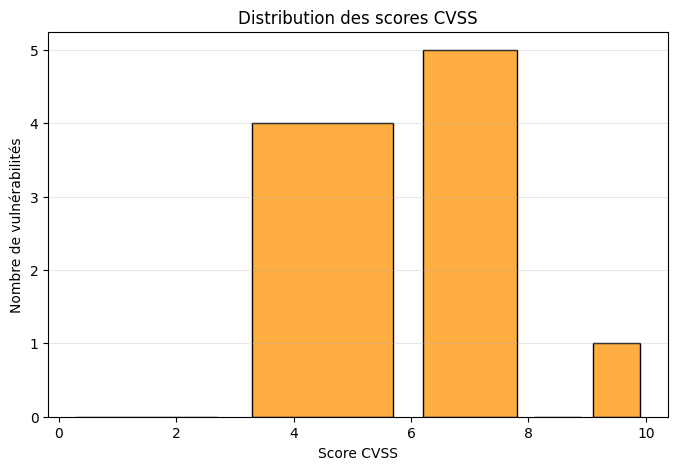

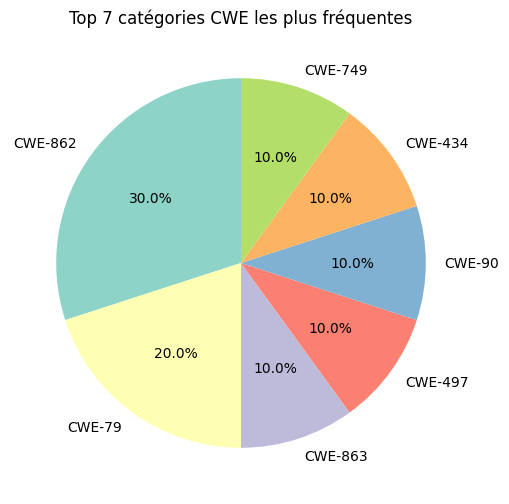

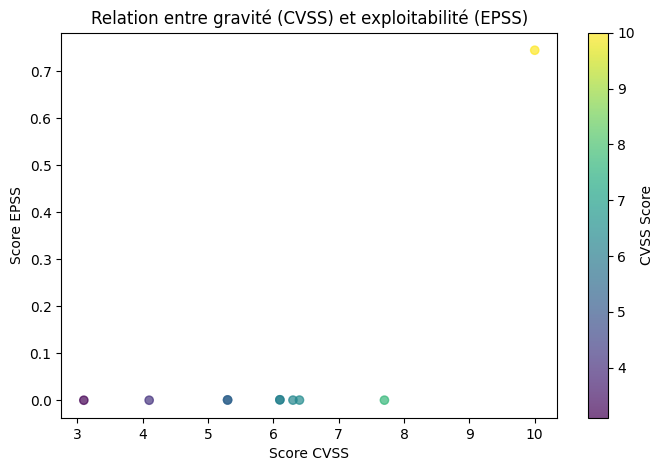

C:\Users\Seb\AppData\Local\Temp\ipykernel_17708\1804159428.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors.values, y=top_vendors.index, palette="crest")


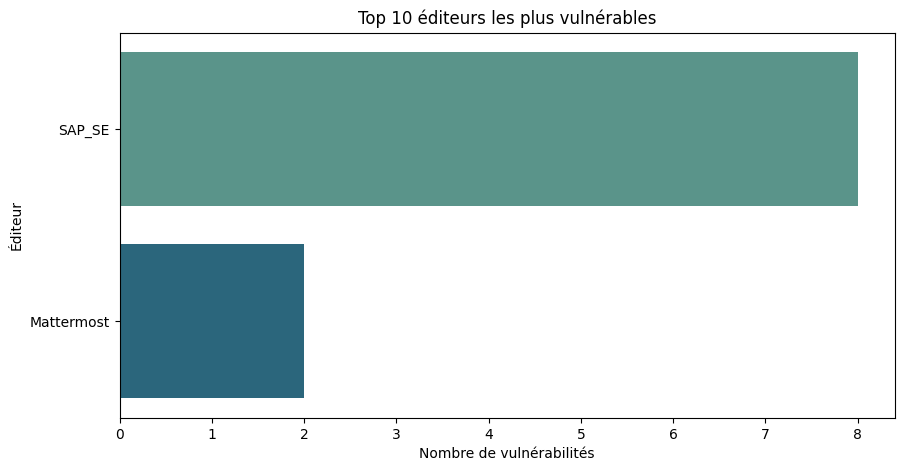

C:\Users\Seb\AppData\Local\Temp\ipykernel_17708\1804159428.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  vul_per_month = df_final.groupby(df_final["Date"].dt.to_period("M")).size()
c:\Users\Seb\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


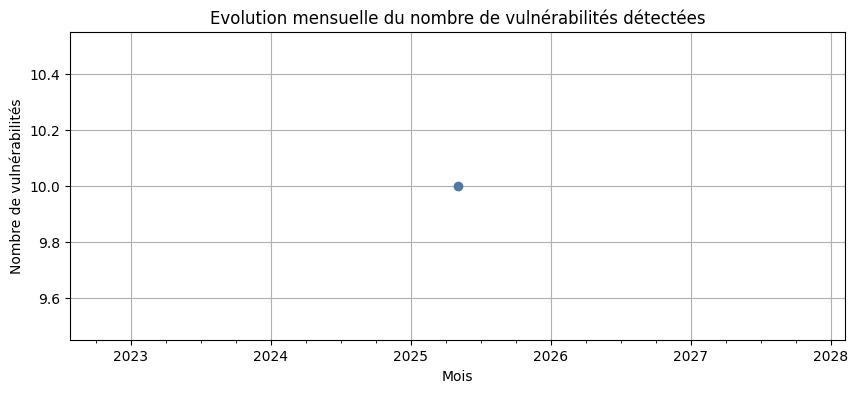

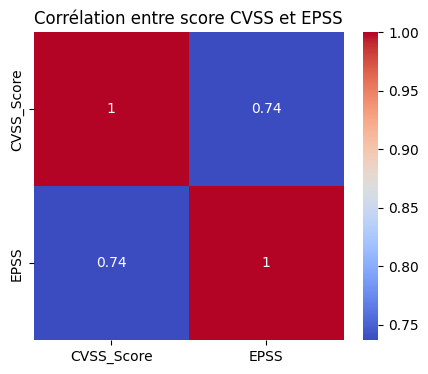

Plotly non disponible: Mime type rendering requires nbformat>=4.2.0 but it is not installed


C:\Users\Seb\AppData\Local\Temp\ipykernel_17708\1804159428.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




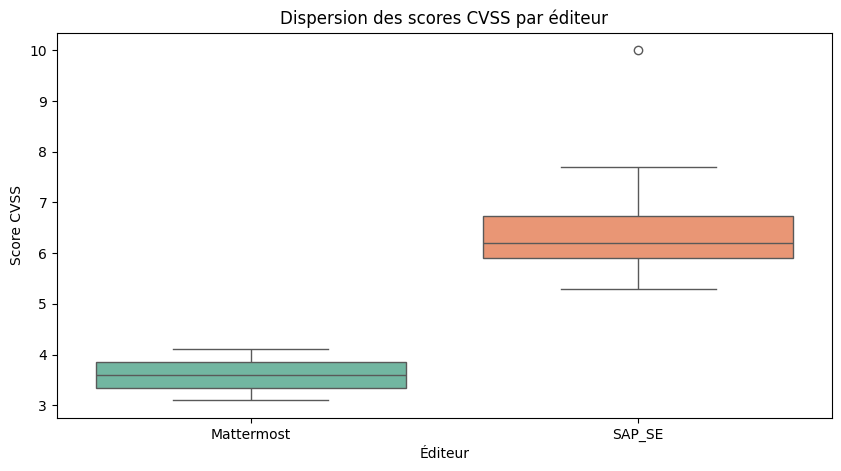

Vulnérabilités critiques & exploitables à traiter en priorité (1) :


,CVE,CVSS_Score,EPSS,Product,Vendor,CWE
5,CVE-2025-31324,10.0,0.74446,SAP NetWeaver (Visual Composer development ser...,SAP_SE,CWE-434


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nettoyage & conversions de colonnes
df_final["CVSS_Score"] = pd.to_numeric(df_final["CVSS_Score"], errors='coerce')
df_final["EPSS"] = pd.to_numeric(df_final["EPSS"], errors='coerce')

# 1. Histogramme CVSS
plt.figure(figsize=(8,5))
plt.hist(df_final["CVSS_Score"].dropna(), bins=[0,3,6,8,9,10], color="#ffae42", edgecolor="black", rwidth=0.8)
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Pie chart des principales catégories CWE
plt.figure(figsize=(6,6))
df_final["CWE"].value_counts().head(7).plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title("Top 7 catégories CWE les plus fréquentes")
plt.ylabel("")
plt.show()

# 3. Scatter CVSS/EPSS
plt.figure(figsize=(8,5))
plt.scatter(df_final["CVSS_Score"], df_final["EPSS"], c=df_final["CVSS_Score"], cmap='viridis', alpha=0.7)
plt.colorbar(label='CVSS Score')
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.title("Relation entre gravité (CVSS) et exploitabilité (EPSS)")
plt.show()

# 4. Top éditeurs les plus affectés
if "Vendor" in df_final.columns:
    top_vendors = df_final["Vendor"].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_vendors.values, y=top_vendors.index, palette="crest")
    plt.title("Top 10 éditeurs les plus vulnérables")
    plt.xlabel("Nombre de vulnérabilités")
    plt.ylabel("Éditeur")
    plt.show()

# 5. Evolution temporelle des vulnérabilités détectées
if "Date" in df_final.columns:
    df_final["Date"] = pd.to_datetime(df_final["Date"], errors="coerce")
    vul_per_month = df_final.groupby(df_final["Date"].dt.to_period("M")).size()
    vul_per_month.plot(kind="line", marker='o', figsize=(10,4), color="#4e79a7")
    plt.title("Evolution mensuelle du nombre de vulnérabilités détectées")
    plt.xlabel("Mois")
    plt.ylabel("Nombre de vulnérabilités")
    plt.grid()
    plt.show()

# 6. Heatmap corrélation CVSS/EPSS
plt.figure(figsize=(5,4))
sns.heatmap(df_final[["CVSS_Score", "EPSS"]].corr(), annot=True, cmap="coolwarm")
plt.title("Corrélation entre score CVSS et EPSS")
plt.show()

# 7. Visualisation interactive Plotly (optionnel, pour les oraux/dashboards)
try:
    import plotly.express as px
    fig = px.scatter(df_final, x="CVSS_Score", y="EPSS",
                     hover_data=["CVE"] if "CVE" in df_final.columns else None,
                     color="CVSS_Score", color_continuous_scale="plasma",
                     title="(Plotly) CVSS vs EPSS - Vulnérabilités")
    fig.show()
except Exception as e:
    print("Plotly non disponible:", e)

# 8. Boxplot (dispersion) des scores CVSS par éditeur (pour les 5 plus gros)
if "Vendor" in df_final.columns:
    top5_vendors = df_final["Vendor"].value_counts().head(5).index
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df_final[df_final["Vendor"].isin(top5_vendors)],
                x="Vendor", y="CVSS_Score", palette="Set2")
    plt.title("Dispersion des scores CVSS par éditeur")
    plt.xlabel("Éditeur")
    plt.ylabel("Score CVSS")
    plt.show()

# 9. Synthèse vulnérabilités critiques à traiter en urgence
vuln_urgentes = df_final[(df_final["CVSS_Score"] >= 8) & (df_final["EPSS"] >= 0.7)]
print(f"Vulnérabilités critiques & exploitables à traiter en priorité ({len(vuln_urgentes)}) :")
display(vuln_urgentes[["CVE","CVSS_Score","EPSS","Product","Vendor","CWE"]].head())

# ---- ASTUCES POUR LE TD ----
# 1. Adapte les noms de colonnes si différents dans ton CSV.
# 2. Pour les dates ou colonnes multiples, vérifie leur format avant.
# 3. Mets des commentaires Markdown pour interpréter tes graphes.
# 4. Recycle ce code : c’est clé en main pour la soutenance.



## Étape 6 : Machine Learning

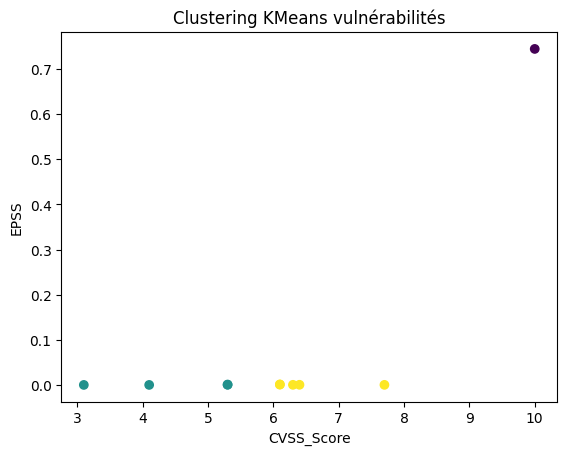

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [18]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Clustering (KMeans sur CVSS et EPSS)
X = df_final[["CVSS_Score", "EPSS"]].dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_final.loc[X.index, "Cluster"] = kmeans.labels_

plt.scatter(X["CVSS_Score"], X["EPSS"], c=kmeans.labels_)
plt.xlabel("CVSS_Score")
plt.ylabel("EPSS")
plt.title("Clustering KMeans vulnérabilités")
plt.show()

# Classification (supervisé) : Prédire la criticité
df_final["Critique"] = (df_final["CVSS_Score"] >= 9).astype(int)
X = df_final[["CVSS_Score", "EPSS"]].dropna()
y = df_final.loc[X.index, "Critique"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


## Étape 7 : Génération d'alertes et notifications email

In [19]:
# Détection des vulnérabilités critiques
crit = df_final[(df_final["CVSS_Score"] >= 9) & (df_final["EPSS"] >= 0.8)]
print(f"{len(crit)} vulnérabilités critiques détectées.")
for _, row in crit.iterrows():
    print(f"ALERTE : {row['CVE']} - {row['Description']} (Produit: {row['Product']})")

# Fonction d’envoi d’email (à personnaliser)
import smtplib
from email.mime.text import MIMEText

def send_email(to_email, subject, body):
    from_email = "votre_email@gmail.com"
    password = "mot_de_passe_application"
    msg = MIMEText(body)
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, password)
    server.sendmail(from_email, to_email, msg.as_string())
    server.quit()

# Exemple d’envoi (à activer avec tes infos !)
# send_email("destinataire@email.com", "Alerte CVE critique", "Mettez à jour votre serveur Apache immédiatement.")


0 vulnérabilités critiques détectées.
